In [2]:
from multiprocessing import Process, Queue
import glob
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import math as m
%matplotlib inline

plt.style.use('ggplot')

path = r'/data/developer/python'    
allFiles = glob.glob(path + "/SQL_Metrics*.csv")     
list_ = []
for file_ in allFiles:
    regex = re.search('SQL_Metrics_([0-9]*-[0-9]*-[0-9]*)-([0-9]*)', file_)
    df = pd.read_csv(file_,sep = '@',names = ['stmt_hash','query','exec_time'],index_col=False)
    df['date'] = regex.group(1)
    df['hour'] = regex.group(2)
    df.exec_time = pd.to_numeric(df.exec_time,errors='coerce')
    df.hour = pd.to_numeric(df.hour,errors='coerce')
    list_.append(df)
fdf = pd.concat(list_,ignore_index=True)

In [3]:
fdf = fdf.set_index(['date', 'hour'])
ds = fdf.groupby(fdf.index)['exec_time'].mean()

datehour_list = []
for x in ds.index:
    datehour_list.append((x[0],x[1]))
datehour_df = pd.DataFrame(datehour_list,columns = ['date','hour'])
exec_time_df = pd.DataFrame(ds.values,columns=['avg_exec_time'])
final_df = datehour_df.merge(exec_time_df, left_index = True, right_index=True, how='inner')

final_df = final_df.set_index(['date', 'hour'])

In [4]:
fields = ['time','lock_wait_time','total_section_sort_time','diaglog_write_wait_time','direct_read_time','direct_write_time','log_buffer_wait_time','log_disk_wait_time','pool_read_time','pool_write_time','prefetch_wait_time','total_act_time','total_act_wait_time','total_cpu_time','total_extended_latch_wait_time','span']
path = r'/data/developer/python'    
allFiles = glob.glob(path + "/workload_stats*.csv")     
list_ = []
for file_ in allFiles:
    regex = re.search('SQL_Metrics_([0-9]*-[0-9]*-[0-9]*)', file_)
    wldf = pd.read_csv(file_,sep = '@',names = fields,index_col=False)
    wldf['hour'] = 0
    wldf['date'] = 0
    for i in range (0,len(wldf)):
        regex = re.search('([0-9-]*)T([0-9]*)', wldf.loc[i,('time')])
        hour_int = int(regex.group(2)) + 1 
        wldf.loc[i,('date')] = regex.group(1)
        wldf.loc[i,('hour')] = hour_int
        list_.append(wldf)
final_wldf = pd.concat(list_,ignore_index=True)
final_wldf = final_wldf.set_index(['date', 'hour'])
final_wldf.drop('time',axis=1,inplace = True)
final_wldf.drop('span',axis=1,inplace = True)

In [5]:
final_df = final_df.merge(final_wldf, left_index = True, right_index=True, how='inner')

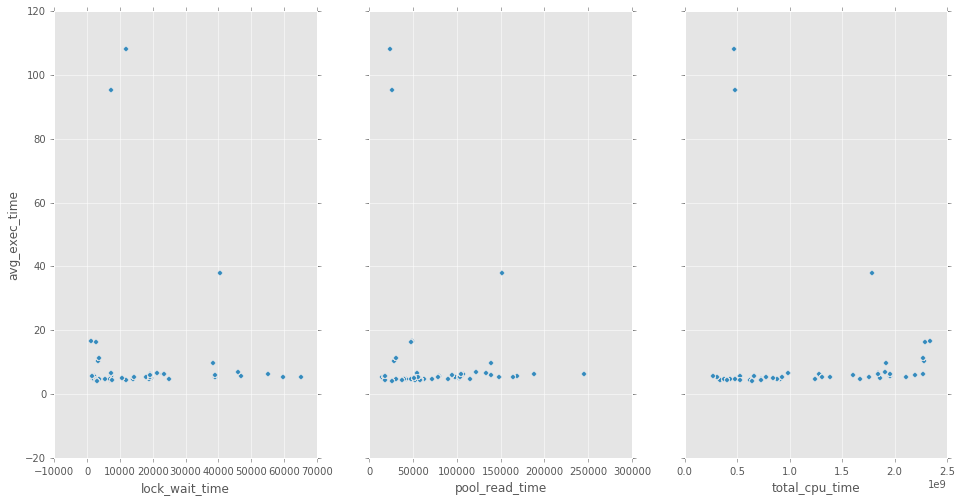

In [14]:
fig, axs = plt.subplots(1, 3, sharey=True)
final_df.plot(kind='scatter', x='lock_wait_time', y='avg_exec_time', ax=axs[0], figsize=(16, 8))
final_df.plot(kind='scatter', x='pool_read_time', y='avg_exec_time', ax=axs[1])
final_df.plot(kind='scatter', x='total_cpu_time', y='avg_exec_time', ax=axs[2])


In [55]:
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='avg_exec_time ~ log_buffer_wait_time', data=final_df).fit()
lm2 = smf.ols(formula='avg_exec_time ~ lock_wait_time', data=final_df).fit()
lm3 = smf.ols(formula='avg_exec_time ~ total_cpu_time', data=final_df).fit()
lm4 = smf.ols(formula='avg_exec_time ~ log_disk_wait_time', data=final_df).fit()

print (lm1.params)
print (lm1.params)
print (lm2.params)
print (lm4.params)

Intercept               12.321219
log_buffer_wait_time    -0.001134
dtype: float64
Intercept               12.321219
log_buffer_wait_time    -0.001134
dtype: float64
Intercept         12.610800
lock_wait_time    -0.000065
dtype: float64
Intercept             15.778549
log_disk_wait_time    -0.000041
dtype: float64


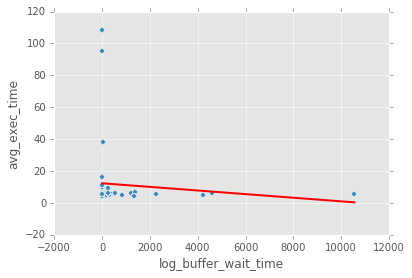

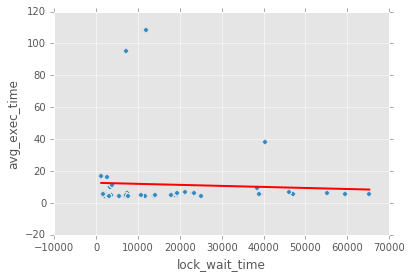

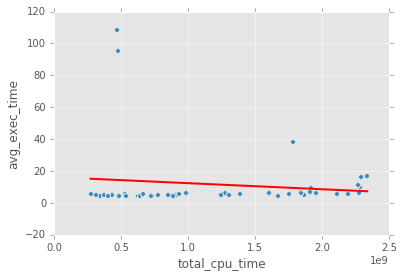

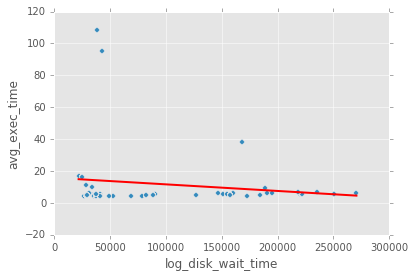

In [57]:
X_new1 = pd.DataFrame({'log_buffer_wait_time': [final_df.log_buffer_wait_time.min(), final_df.log_buffer_wait_time.max()]})
preds1 = lm1.predict(X_new1)

X_new2 = pd.DataFrame({'lock_wait_time': [final_df.lock_wait_time.min(), final_df.lock_wait_time.max()]})
preds2 = lm2.predict(X_new2)

X_new3 = pd.DataFrame({'total_cpu_time': [final_df.total_cpu_time.min(), final_df.total_cpu_time.max()]})
preds3 = lm3.predict(X_new3)

X_new4 = pd.DataFrame({'log_disk_wait_time': [final_df.log_disk_wait_time.min(), final_df.log_disk_wait_time.max()]})
preds4 = lm4.predict(X_new4)

#fig, axs = plt.subplots(1, 3, sharey=True)

final_df.plot(kind='scatter', x='log_buffer_wait_time', y='avg_exec_time')
plt.plot(X_new1, preds1, c='red', linewidth=2)

final_df.plot(kind='scatter', x='lock_wait_time', y='avg_exec_time')
plt.plot(X_new2, preds2, c='red', linewidth=2)

final_df.plot(kind='scatter', x='total_cpu_time', y='avg_exec_time')
plt.plot(X_new3, preds3, c='red', linewidth=2)

final_df.plot(kind='scatter', x='log_disk_wait_time', y='avg_exec_time')
plt.plot(X_new4, preds4, c='red', linewidth=2)